In [15]:
%matplotlib inline

# Memory footprint

| Data size M| Required hardware         |
|---|---|
| M<8GB      | RAM (single machine)      |
| 8GB<M<10TB | hard disk (single machine)|
| M>10TB   | specialized hardware      |


In [16]:
import psutil, os

def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

In [17]:
import numpy as np

before = memory_footprint()
N = (1024 ** 2) // 8 # Number of floats that fill 1 MB
x = np.random.randn(50*N) # Random array filling 50 MB
after = memory_footprint()
print('Memory before: {} MB'.format(before))
print('Memory after: {} MB'.format(after))

Memory before: 90.07421875 MB
Memory after: 140.0859375 MB


In [18]:
x.nbytes // (1024**2)

50

In [19]:
import pandas as pd

df = pd.DataFrame(x)
df.memory_usage(index=False)

0    52428800
dtype: int64

### Using Dask delayed function to manage memory

In [20]:
from dask import delayed
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

In [48]:
filenames = ['dc_flightdelays-2016-1.csv',
     'dc_flightdelays-2016-2.csv',
     'dc_flightdelays-2016-3.csv',
     'dc_flightdelays-2016-4.csv',
     'dc_flightdelays-2016-5.csv']

n_delayed = []
n_flights = []

@delayed
def read_one(filename):
    return pd.read_csv(filename)

for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed,n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824


### Dask dataframes

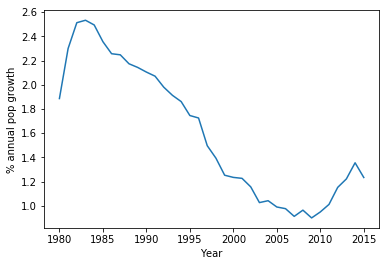

In [44]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

df = dd.read_csv('dc_WDI.csv')

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'SP.POP.GROW'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df[toxins & region]

# Grouby filtered by the 'Year' column: yearly
yearly = filtered.groupby('Year')

# Aggregate the mean of the groupby object: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean.compute()

# Plot the 'value' column with .plot.line()
result['value'].plot.line()
plt.ylabel('% annual pop growth')
plt.show()

# Case study: Flight Delays

In [45]:
@delayed
def read_flights(filename):

    # Read in the DataFrame: df
    df = pd.read_csv(filename, parse_dates=['FL_DATE'])

    # Calculate df['WEATHER_DELAY']
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0,np.nan)

    # Return df
    return df

In [50]:
filenames = ['dc_flightdelays-2016-1.csv',
     'dc_flightdelays-2016-2.csv',
     'dc_flightdelays-2016-3.csv',
     'dc_flightdelays-2016-4.csv',
     'dc_flightdelays-2016-5.csv']
dataframes = []

for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
print(flight_delays['WEATHER_DELAY'].mean().compute())

51.29467680608365


In [55]:
@delayed
def read_weather(filename):
    # Read in filename: df
    df = pd.read_csv('dc_weatherdata/'+filename, parse_dates=['Date'])

    # Clean 'PrecipitationIn'
    df['PrecipitationIn'] = pd.to_numeric(df['PrecipitationIn'], errors='coerce')

    # Create the 'Airport' column
    df['Airport'] = filename.split('.')[0]

    # Return df
    return df

In [56]:
filenames = ['ATL.csv', 'DEN.csv', 'DFW.csv', 'MCO.csv', 'ORD.csv']

weather_dfs=[]

for filename in filenames:
    # Invoke read_weather on filename; append result to weather_dfs
    weather_dfs.append(read_weather(filename))

# Call dd.from_delayed() with weather_dfs: weather
weather = dd.from_delayed(weather_dfs)

# Print result of weather.nlargest(1, 'Max TemperatureF')
print(weather.nlargest(1, 'Max TemperatureF').compute())

          Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
224 2016-08-12               107                 93                79   

     Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
224              75              71             66            79   

     Mean Humidity  Min Humidity   ...     Mean VisibilityMiles  \
224             53            27   ...                        8   

     Min VisibilityMiles  Max Wind SpeedMPH  Mean Wind SpeedMPH  \
224                    0                 41                  10   

     Max Gust SpeedMPH  PrecipitationIn  CloudCover             Events  \
224               54.0             0.82           5  Rain-Thunderstorm   

     WindDirDegrees  Airport  
224             214      DFW  

[1 rows x 24 columns]


In [57]:
# Make cleaned Boolean Series from weather['Events']: is_snowy
is_snowy = weather['Events'].str.contains('Snow').fillna(False)

# Create filtered DataFrame with weather.loc & is_snowy: got_snow
got_snow = weather.loc[is_snowy]

# Groupby 'Airport' column; select 'PrecipitationIn'; aggregate sum(): result
result = got_snow.groupby('Airport')['PrecipitationIn'].sum()

# Compute & print the value of result
print(result.compute())

Airport
ATL    1.94
DEN    5.59
ORD    3.91
Name: PrecipitationIn, dtype: float64


### Persisting merged dataframe

In [65]:
import time

weather_delays = flight_delays[['FL_DATE','ORIGIN','WEATHER_DELAY']].merge(weather[['Date','Events','Airport']], left_on=['FL_DATE', 'ORIGIN'], right_on=['Date', 'Airport'])

def percent_delayed(df):
    return (df['WEATHER_DELAY'].count() / len(df)) * 100

# Print time in milliseconds to compute percentage_delayed on weather_delays
t_start = time.time()
print(percent_delayed(weather_delays).compute())
t_end = time.time()
print((t_end-t_start)*1000)

# Call weather_delays.persist(): persisted_weather_delays
persisted_weather_delays = weather_delays.persist()

# Print time in milliseconds to compute percentage_delayed on persisted_weather_delays
t_start = time.time()
print(percent_delayed(persisted_weather_delays).compute())
t_end = time.time()
print((t_end-t_start)*1000)

1.304773408863712
2917.2232151031494
1.304773408863712
5.877017974853516


In [66]:
# Group persisted_weather_delays by 'Events': by_event
by_event = persisted_weather_delays.groupby('Events')

# Count 'by_event['WEATHER_DELAY'] column & divide by total number of delayed flights
pct_delayed = (by_event['WEATHER_DELAY'].count()/persisted_weather_delays['WEATHER_DELAY'].count())*100

# Compute & print five largest values of pct_delayed
print(pct_delayed.nlargest(5).compute())

# Calculate mean of by_event['WEATHER_DELAY'] column & return the 5 largest entries: avg_delay_time
avg_delay_time = by_event['WEATHER_DELAY'].mean().nlargest(5)

# Compute & print avg_delay_time
print(avg_delay_time.compute())

Events
Rain-Thunderstorm        43.016760
Snow                     17.557861
Fog-Snow                  7.182761
Rain                      6.464485
Fog-Rain-Thunderstorm     4.309657
Name: WEATHER_DELAY, dtype: float64
Events
Rain-Snow                77.725490
Thunderstorm             72.500000
Fog-Rain                 55.000000
Rain-Thunderstorm        47.335807
Fog-Rain-Thunderstorm    39.685185
Name: WEATHER_DELAY, dtype: float64
